<a href="https://colab.research.google.com/github/carloslizarragac/FisicaComputacional1/blob/master/Actividad6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# Pronóstico de Series de Tiempo
# Feb 15, 2021
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline


In [2]:
# En esta celda se hacen todas las operaciones de preparar el DataFrame df_meteo
# 
# En esta nueva Jupyter Notebook, en una celda vamos a concentrar todas las operaciones
# de transformación del dataframe original df_dist

# Analizaremos los datos de Información Estadística Climatológica del Servico Meteorológico Nacional 
# de CONAGUA que podemos descargar del sitio:
# (https://smn.conagua.gob.mx/es/climatologia/informacion-climatologica/informacion-estadistica-climatologica) 

# Tomar la dirección URL del archivo en formato 'raw'
# url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/Guaymas26292.txt'
url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/3061.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()

#df_meteo.info()
#print(df_meteo.head())
#print(df_meteo.tail())

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
df_meteo_ts.info()
#print(df_meteo_ts.head())
#print(df_meteo_ts.tail())

# Seleccionaremos un conjunto de años de 30 años, creando las colecciones de datos 
df_30 = df_meteo_ts[(df_meteo_ts['Año'] >= 1930) & (df_meteo_ts['Año'] < 1960)]
df_60 = df_meteo_ts[(df_meteo_ts['Año'] >= 1960) & (df_meteo_ts['Año'] < 1990)]
df_90 = df_meteo_ts[(df_meteo_ts['Año'] >= 1990) & (df_meteo_ts['Año'] < 2018)]

# Estas 3 colecciones serán nuestras Series de Tiempo (DatFrames) para el análisis



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29804 entries, 1929-11-01 to 2017-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  29786 non-null  float64
 1   Evap    1389 non-null   float64
 2   Tmax    29723 non-null  float64
 3   Tmin    29724 non-null  float64
 4   Año     29804 non-null  int64  
 5   Mes     29804 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.6+ MB


Definimos una función para probar la Estacionaridad de una Serie de Tiempo usando la **Prueba Aumentada de Dickey-Fuller(ADF)**

In [3]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


Definimos la serie de tiempo a probar....

In [4]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1990 a 2017 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '2012-01', '2017-12'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()


,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2012-01-01,0.0,NaN,21.0,12.0,2012,Jan
2012-01-02,0.0,NaN,22.0,12.0,2012,Jan
2012-01-03,0.0,NaN,23.0,11.0,2012,Jan
2012-01-04,0.0,NaN,22.0,13.0,2012,Jan
2012-01-05,0.0,NaN,21.0,12.0,2012,Jan


In [5]:
# Vemos su encabezado
ts_90['Tmax'].head()


Fecha
2012-01-01    21.0
2012-01-02    22.0
2012-01-03    23.0
2012-01-04    22.0
2012-01-05    21.0
Name: Tmax, dtype: float64

In [6]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico

ts_test = ts_90['Tmax'].copy()


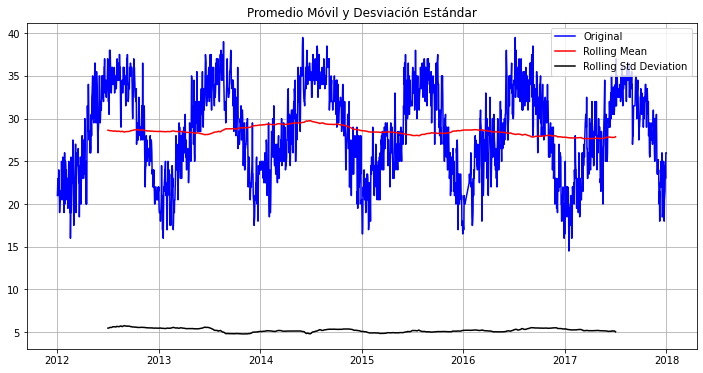

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.626671
p-value                           0.087609
#Lags Used                       16.000000
Number of Observations Used    2160.000000
Critical Value (1%)              -3.433381
Critical Value (5%)              -2.862879
Critical Value (10%)             -2.567483
dtype: float64


In [7]:
# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(ts_test)


Notamos que el promedio móvil no es constante y el valor p de ADF: p > 0.05 (0.0876).

La ***tendencia*** y la ***estacionalidad*** hacen que una serie no sea estacionaria.

Primero trabajaremos para lograr que la ***Tendencia sea constante***.

Hay muchas formas para reducir la tendencia. Es hacer cambio de escalas: log(x), sqrt(x), raiz_cúbica(x),... la idea es disminuir la tendencia para valores grandes de x.




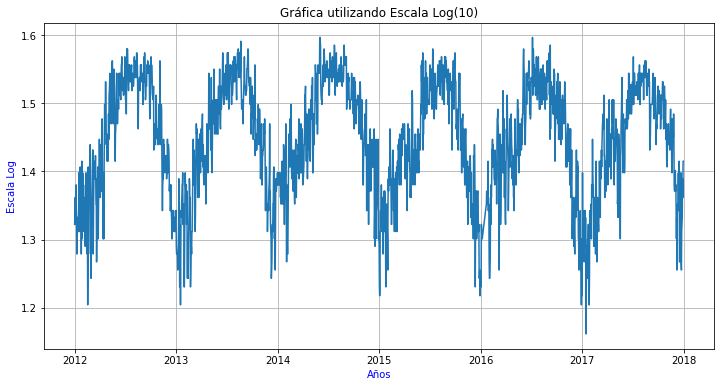

In [8]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();


Vamos a calcular el Promedio móvil de ts_test_log con ventana de 365 y graficar para ver el contraste con la de arriba.   

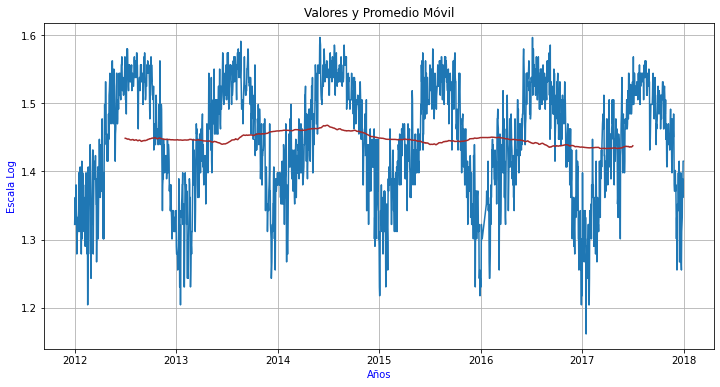

In [9]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();


In [10]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()


Fecha
2012-01-01   NaN
2012-01-02   NaN
2012-01-03   NaN
2012-01-04   NaN
2012-01-05   NaN
Name: Tmax, dtype: float64

In [11]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()


Fecha
2012-07-01    0.095459
2012-07-02    0.056485
2012-07-03    0.056629
2012-07-04    0.056856
2012-07-05    0.036180
Name: Tmax, dtype: float64

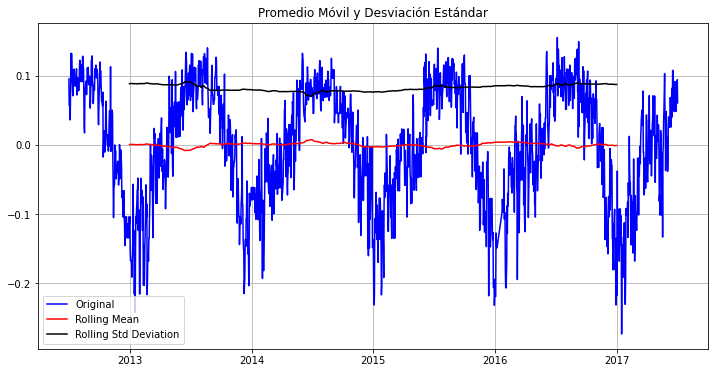

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.729849
p-value                           0.069014
#Lags Used                       13.000000
Number of Observations Used    1799.000000
Critical Value (1%)              -3.433990
Critical Value (5%)              -2.863148
Critical Value (10%)             -2.567626
dtype: float64


In [12]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)


Aún la serie de tiempo no es estacionaria. Cambiaremos el tipo de promedio móvil a Exponencial (Exponential Weighted Moving), función de pandas pd.ewm() 

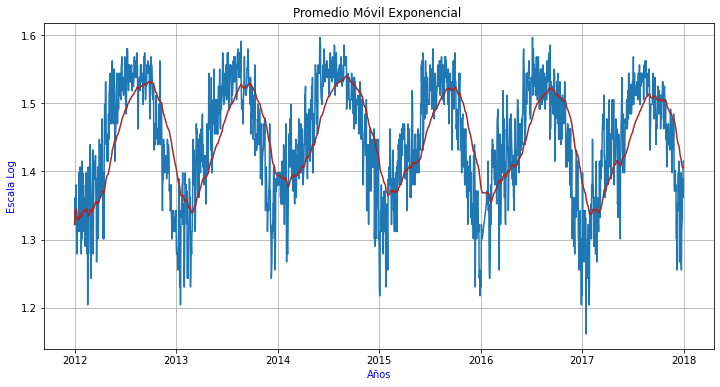

In [13]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();


In [14]:
EWM_avg.head()


Fecha
2012-01-01    1.322219
2012-01-02    1.332438
2012-01-03    1.342427
2012-01-04    1.342426
2012-01-05    1.338196
Name: Tmax, dtype: float64

In [15]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg 


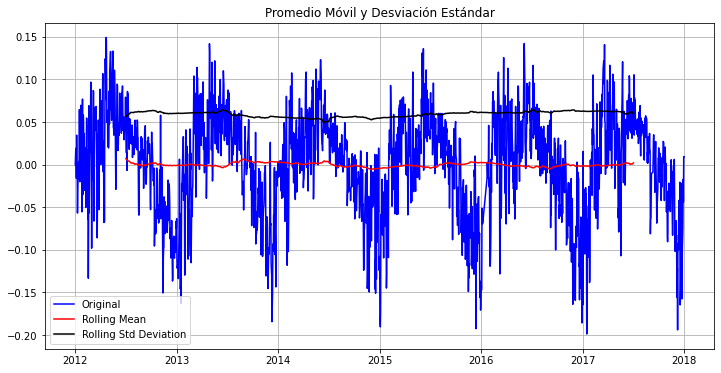

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.631610
p-value                           0.005185
#Lags Used                       16.000000
Number of Observations Used    2160.000000
Critical Value (1%)              -3.433381
Critical Value (5%)              -2.862879
Critical Value (10%)             -2.567483
dtype: float64


In [16]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)


Ahora el valor p < 0.05, es decir que podemos rechazar la hipótesis nula de que la serie de tiempo no es estacionaria y **afirmar que la serie de tiempo es estacionaria con 99% de confianza**. (Hay que jugar con el parámetro 'halflife', en este caso se usaron 30 días).

Podemos decir que **la serie es estacionaria**, pues tanto el promedio móvil exponencial y la desviación estandar son constantes. 

Ahora vamos a trabajar con la ***estacionalidad*** (variaciones debido a las estaciones del año)

Existen dos métodos para eliminar la Estacionalidad:


*   Diferenciación discreta (calcular diferencias involucrando un corrimiento 'shift()')
*   Descomposición (Tendencia + Estacionalidad + Residuo) - lo vimos en la actividad pasada. 




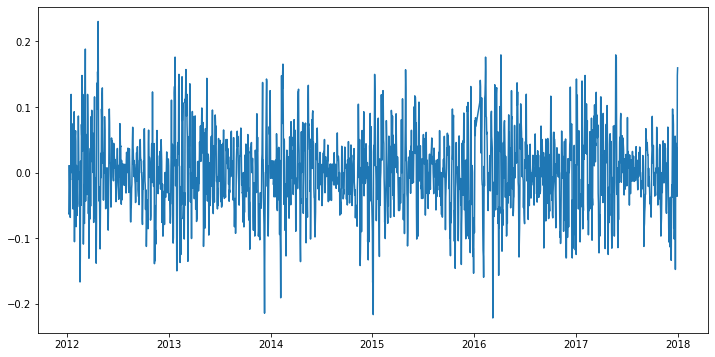

In [17]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);


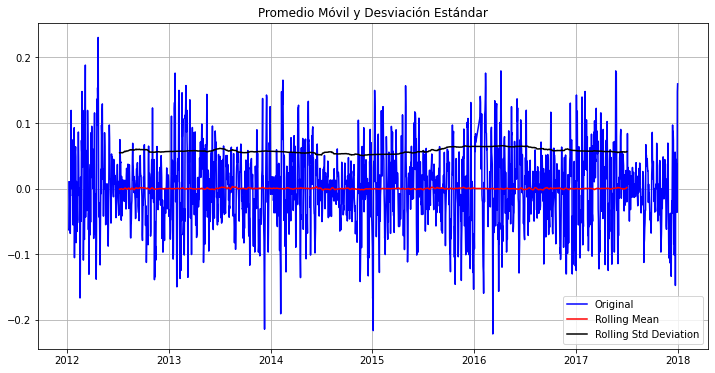

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.986665e+00
p-value                        7.070735e-15
#Lags Used                     2.600000e+01
Number of Observations Used    2.143000e+03
Critical Value (1%)           -3.433405e+00
Critical Value (5%)           -2.862890e+00
Critical Value (10%)          -2.567488e+00
dtype: float64


In [18]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)


In [24]:
# Número de datos utilizados
len(ts_test_log_diff)

2170

Podemos decir que es estacionaria, el valor p < 0.05 y la desviación estándar no varía mucho.

Pero la estacionalidad domina. 

Veamos el siguiente ***método de descomposición*** que utilzamos en la actividad anterior.



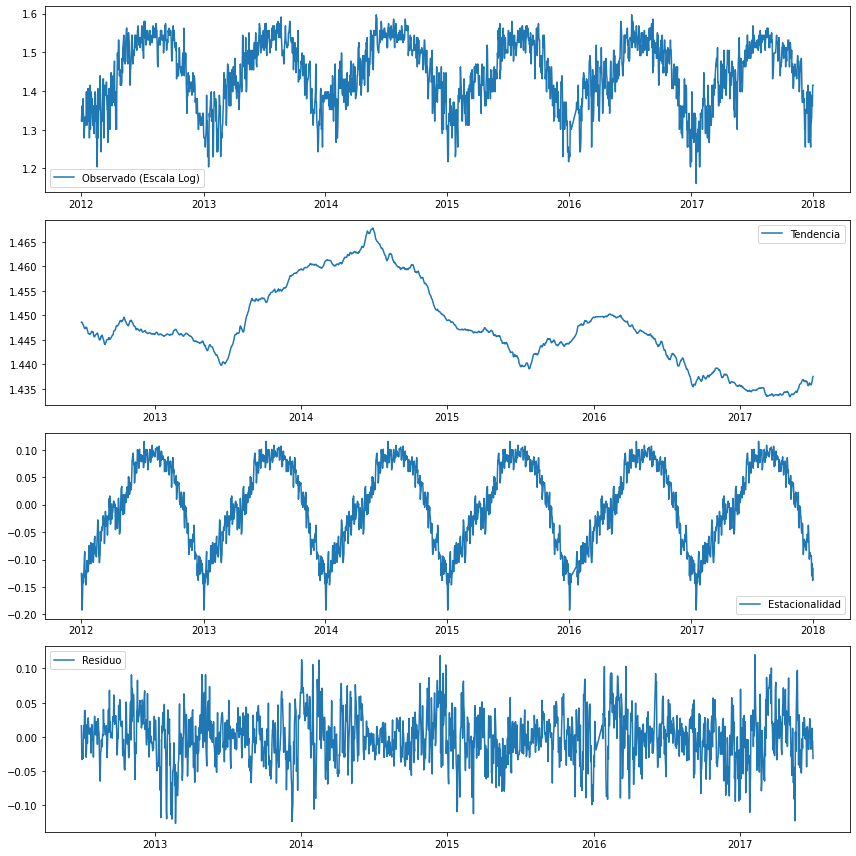

In [21]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();



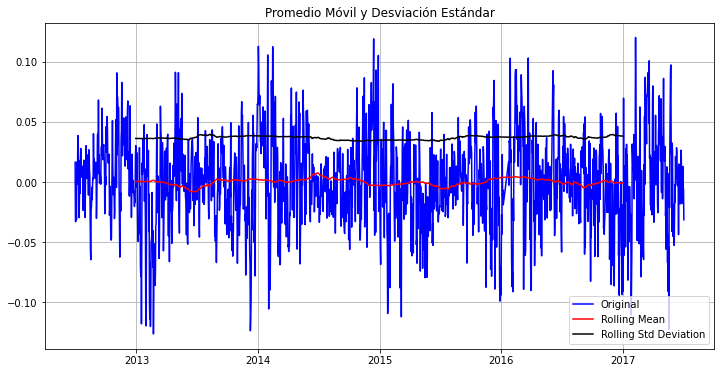

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.659549e+00
p-value                        4.864337e-14
#Lags Used                     1.300000e+01
Number of Observations Used    1.799000e+03
Critical Value (1%)           -3.433990e+00
Critical Value (5%)           -2.863148e+00
Critical Value (10%)          -2.567626e+00
dtype: float64


In [22]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)


Esta serie es estacionaria porque la prueba da un valor de p < 0.05 (4.86 x 10^(-14)). Podemos afirmar que ***es una serie de tiempo estacionaria con mas de un 99% de confianza***. 


## **Pronóstico de Series de Tiempo**

Ya que hemos obtenido una serie de tiempo estacionaria, construiremos un modelo utilizando diferenciación, porque es fácil añadir el error, la tendencia y la estacionalidad a las predicciones. 

Utilizaremos el ***método ARIMA***.

Necesitamos agregar las siguientes 2 líneas en la celda 1, donde cargamos las bibliotecas a la memoria de trabajo.

from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import acf, pacf

Usaremos propiedades de la [Distribución Normal centrada en el promedio y std dev=1](https://en.wikipedia.org/wiki/1.96), donde el 95% de los datos caen entre -1.96 y 1.96.

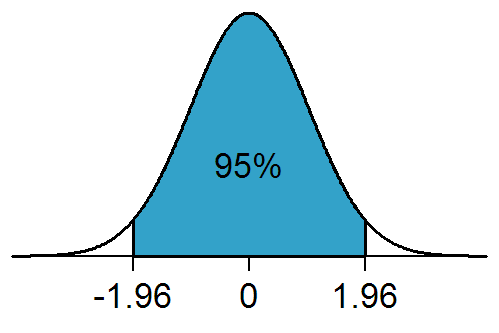



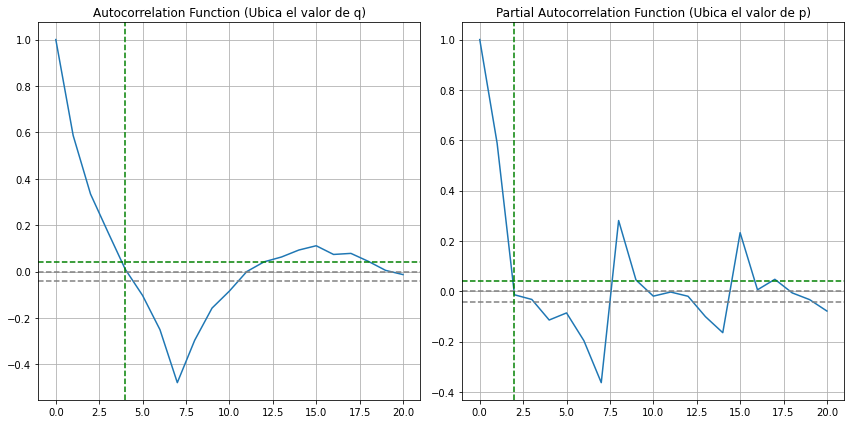

In [66]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()



Las líneas punteadas alrededor de cero representan los intervalos de confianza y nos serviran para determinar los valores ***p*** y ***q*** del modelo ARIMA.

p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.

q es donde cruza la ACF el primer nivel de confianza superior, cercano a 4, por lo que haremos q=4.  

Con estos dos valores construiremos los modelos ARIMA correspondientes.


## **Modelo AR (Auto-Regresión)**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2176
Model:                 ARIMA(2, 1, 0)   Log Likelihood                4147.267
Method:                       css-mle   S.D. of innovations              0.036
Date:                Tue, 16 Feb 2021   AIC                          -8286.534
Time:                        08:08:51   BIC                          -8263.793
Sample:                             1   HQIC                         -8278.220
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          3.62e-05      0.001      0.068      0.946      -0.001       0.001
ar.L1.D.Tmax    -0.2909      0.021    -13.735      0.000      -0.332      -0.249
ar.L2.D.Tmax    -0.1548      0.021     -7.30

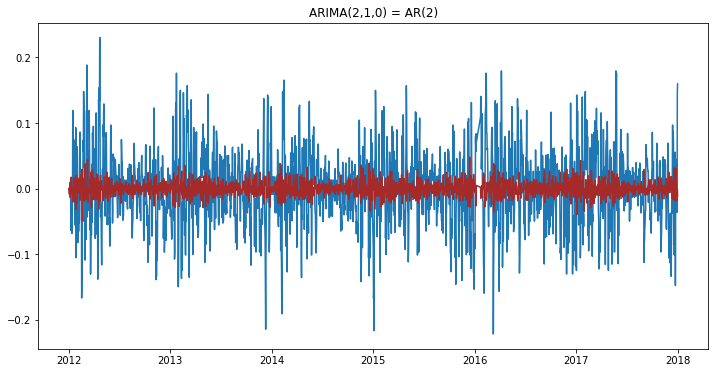

In [69]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())


## **Modelo MA (Promedio Móvil)**


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2176
Model:                 ARIMA(0, 1, 4)   Log Likelihood                4238.544
Method:                       css-mle   S.D. of innovations              0.034
Date:                Tue, 16 Feb 2021   AIC                          -8465.088
Time:                        07:17:11   BIC                          -8430.977
Sample:                             1   HQIC                         -8452.616
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.324e-05      0.000      0.071      0.943      -0.000       0.000
ma.L1.D.Tmax    -0.3855      0.021    -18.031      0.000      -0.427      -0.344
ma.L2.D.Tmax    -0.1620      0.023     -7.19

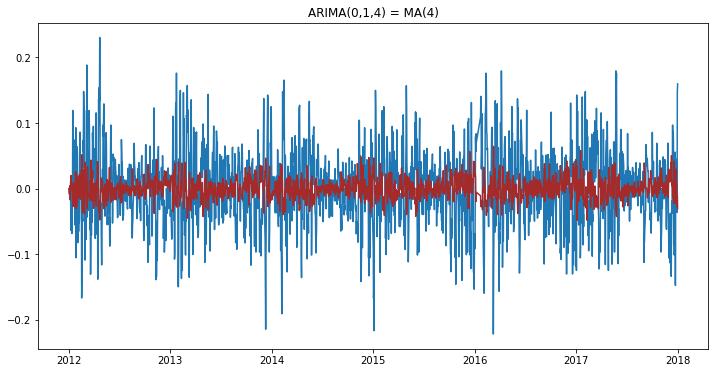

In [60]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())


## **Modelo ARIMA (Auto-Regresión + Promedio Móvil)**



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2176
Model:                 ARIMA(2, 1, 4)   Log Likelihood                4242.817
Method:                       css-mle   S.D. of innovations              0.034
Date:                Tue, 16 Feb 2021   AIC                          -8469.635
Time:                        07:18:00   BIC                          -8424.153
Sample:                             1   HQIC                         -8453.006
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.325e-05      0.000      0.073      0.942      -0.000       0.000
ar.L1.D.Tmax    -0.4427      0.104     -4.245      0.000      -0.647      -0.238
ar.L2.D.Tmax     0.3390      0.095      3.55

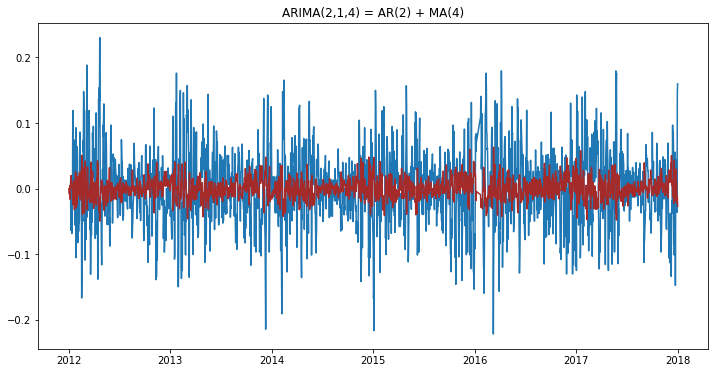

In [61]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())


El [Criterio de Información de Akaike (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion), como indicador del mejor modelo ARIMA. 

El criterio AIC se basa en dos principios:


*   Bondad del ajuste
*   Simplicidad del modelo o principio de parsimonia.

Aquel modelo que tenga el menor AIC, y los valores más pequeños de (p,d,q) se selecciona como el mejor modelo de ajuste. 

Cuando imprimimos los resúmenes de los modelos con la función results.summary(), nos regresa una serie de valores y parámetros. 

Entre ellos se encuentra el criterio AIC.

ARIMA(2,1,0): AIC = -8286.534

ARIMA(0,1,4): AIC = -8465.088

**ARIMA(2,1,4): AIC =** **-8469.635 <- Es el menor AIC**

Podemos afirmar que **ARIMA(2,1,4) es el mejor modelo** de los 3 que exploramos. 
